In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import time

from dotenv import load_dotenv
sys.path.insert(0, '..')

from core.genetic_algorithm.ga_bounds import DesignSpaceBounds
from core.genetic_algorithm.ga_params import GeneticAlgorithmParams
from core.genetic_algorithm.ga_run import GeneticAlgorithm

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances

## Environment Variables

In [2]:
load_dotenv(dotenv_path='../core/.env')

True

In [3]:
# General AWS config
ACCOUNT_ID        = os.getenv("ACCOUNT_ID")
ACCESS_KEY_ID     = os.getenv("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.getenv("SECRET_ACCESS_KEY")
VPC_ID            = os.getenv("VPC_ID")
SG_ID             = os.getenv("SG_ID")
EC2_PUBLIC_IP     = os.getenv("EC2_PUBLIC_IP")

# Smartfarm-specific AWS config
AWS_REGION    = os.getenv("AWS_REGION")
BUCKET        = os.getenv("BUCKET")
ROOT_PREFIX   = os.getenv("ROOT_PREFIX")
FUNCTION_NAME = os.getenv("FUNCTION_NAME")

## Model Parameters

In [4]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt = 0.1, # hours/step
    simulation_hours = 2900 # hours
)

In [5]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [6]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [7]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Design Space

In [8]:
lower_bounds_dict = {
    "irrigation_frequency":    24,     # once every X hours
    "irrigation_amount":       0.001, # inches per irrigation
    "fertilization_frequency": 24,    # once every X hours (once a day)
    "fertilization_amount":    0.001  # pounds per fertilization
}
lower_bounds = np.array([value for key, value in lower_bounds_dict.items()])

In [9]:
upper_bounds_dict = {
    "irrigation_frequency":    24 * 7 * 2,   # once every 2 weeks
    "irrigation_amount":       1,            # inches per irrigation
    "fertilization_frequency": 30 * 24 * 3,  # once every 3 months
    "fertilization_amount":    1             # pounds per fertilization
}
upper_bounds = np.array([value for key, value in upper_bounds_dict.items()])

In [10]:
# Set DesignSpaceBounds
bounds = DesignSpaceBounds(
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds
)

## Genetic Algorithm Parameters

In [11]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams(
    num_parents     = 16,  # number of design strings to breed
    num_kids        = 16,  # number of offspring design strings
    num_generations = 200, # number of generations
    num_members     = 128, # number of simulations per generation
)

## Input Disturbances

In [12]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../io/inputs/hourly_prcp_rad_temp_iowa.csv',
    header=None,
    names=[
        'Hourly Precipitation (mm)',
        'Hourly Radiation (W/m2)',
        'Temperature (C)'
    ]
)

In [13]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (mm)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Optimal/Typical Values

In [14]:
typical_disturbances = ModelTypicalDisturbances(
        optimal_cumulative_water      = 28,  # inches/acre per season
        optimal_cumulative_fertilizer = 355, # lbs/acre per season
        typical_temperature           = np.mean(input_disturbances.temperature),   # typical temperature over the season
        typical_radiation             = 3/4 * np.max(input_disturbances.radiation) # typical radiation over the season
    )

## Genetic Algorithm

In [15]:
# Create GeneticAlgorithm object from all inputs
GeneticAlgorithm = GeneticAlgorithm(
    bounds               = bounds,
    ga_params            = ga_params,
    model_params         = model_params,
    carrying_capacities  = carrying_capacities,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    disturbances         = input_disturbances,
    typical_disturbances = typical_disturbances
)

In [16]:
# Run the Genetic Algorithm and save the result
'''
GeneticAlgorithmResult = GeneticAlgorithm.run_with_lambda()

with open(f"ga_parallel_result.pkl", "wb") as f:
    pickle.dump(GeneticAlgorithmResult, f)
'''

'\nGeneticAlgorithmResult = GeneticAlgorithm.run_with_lambda()\n\nwith open(f"ga_parallel_result.pkl", "wb") as f:\n    pickle.dump(GeneticAlgorithmResult, f)\n'

In [17]:
'''
with open("ga_parallel_result_1.pkl", "rb") as f:
    result = pickle.load(f)
'''

'\nwith open("ga_parallel_result_1.pkl", "rb") as f:\n    result = pickle.load(f)\n'

In [18]:
#[unique_values, unique_costs] = result.final_population.get_unique_designs()

In [19]:
'''
fig, ax = plt.subplots(figsize=(8, 5))

member_ids = np.arange(unique_costs.shape[0])
ax.plot(member_ids, unique_costs)

ax.set_title("Costs across final population", fontsize=16, pad=15)
ax.set_xlabel("Member", fontsize=13)
ax.set_ylabel("Cost", fontsize=13)

fig.tight_layout()
'''

'\nfig, ax = plt.subplots(figsize=(8, 5))\n\nmember_ids = np.arange(unique_costs.shape[0])\nax.plot(member_ids, unique_costs)\n\nax.set_title("Costs across final population", fontsize=16, pad=15)\nax.set_xlabel("Member", fontsize=13)\nax.set_ylabel("Cost", fontsize=13)\n\nfig.tight_layout()\n'

In [20]:
#result.plot_optimization_results()

## Analysis across runs

In [ ]:
ga_parallel_results_folder = "ga_parallel_results"
csv_results_folder = "csvs_unique_values_costs"

In [31]:
# Read pickle for run 10
with open(
    os.path.join(
        ga_parallel_results_folder,
        f"pickled_ga_result_objects",
        f"ga_parallel_result_10.pkl"
    ),
    "rb"
) as f:
    result = pickle.load(f)

In [32]:
[unique_values, unique_costs] = result.final_population.get_unique_designs()

# Then save the unique values and costs to csvs
values_path = os.path.join(
    ga_parallel_results_folder,
    csv_results_folder,
    "ga_parallel_result_10_unique_values.csv"
)
costs_path = os.path.join(
    ga_parallel_results_folder,
    csv_results_folder,
    "ga_parallel_result_10_unique_costs.csv"
)

In [34]:
# save the unique values
with open(values_path, "wb") as f:
    np.savetxt(f, unique_values, delimiter=",")

# save the unique costs
with open(costs_path, "wb") as f:
    np.savetxt(f, unique_costs, delimiter=",")

Run 1: Best design string: [1.39009047e+02 1.44190202e-03 2.14449018e+03 9.98529365e-03]
Run 1: Best revenue: 1094.061
Run 2: Best design string: [2.84650780e+02 4.36994136e-03 1.09859770e+03 3.48957219e-03]
Run 2: Best revenue: 1093.763
Run 3: Best design string: [1.88090889e+02 1.47400064e-03 1.62456030e+03 1.10262300e-01]
Run 3: Best revenue: 1092.963
Run 4: Best design string: [2.97396316e+02 3.67697816e-03 1.76323136e+03 3.29880556e-03]
Run 4: Best revenue: 1094.013
Run 5: Best design string: [3.29139244e+02 4.33611537e-03 4.22880301e+02 1.43131633e-02]
Run 5: Best revenue: 1093.393
Run 6: Best design string: [2.87830347e+02 1.61252292e-03 1.49111543e+03 2.48745684e-02]
Run 6: Best revenue: 1094.129
Run 7: Best design string: [2.56908572e+02 2.12647159e-03 8.40673289e+02 2.05533017e-02]
Run 7: Best revenue: 1093.774
Run 8: Best design string: [3.13624317e+02 3.81317242e-03 1.50032167e+03 2.05485680e-02]
Run 8: Best revenue: 1093.774
Run 9: Best design string: [2.30104281e+02 3.277

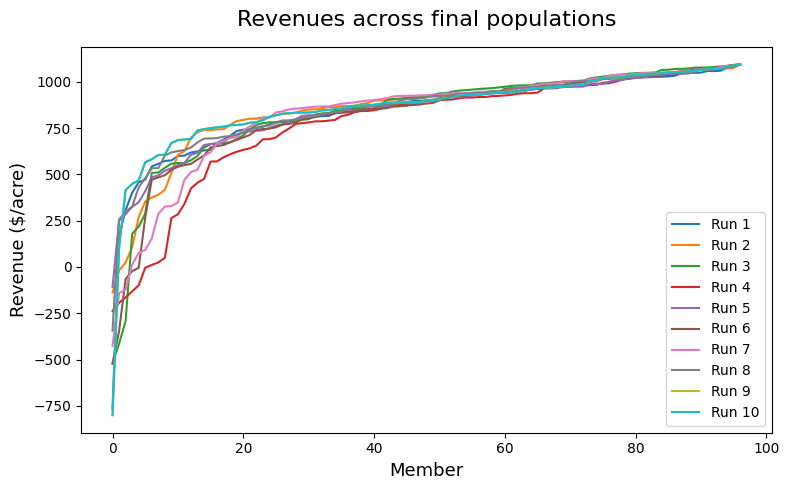

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(1, 11): # Runs 1 to 10

    values_path = os.path.join(
        ga_parallel_results_folder,
        csv_results_folder,
        f"ga_parallel_result_{i}_unique_values.csv"
    )

    costs_path = os.path.join(
        ga_parallel_results_folder,
        csv_results_folder,
        f"ga_parallel_result_{i}_unique_costs.csv"
    )

    with open(values_path, "rb") as f:
        unique_values = np.loadtxt(f, delimiter=",")
        print(f"Run {i}: Best design string: {unique_values[0]}")

    with open(costs_path, "rb") as f:
        unique_costs = np.loadtxt(f, delimiter=",")
        unique_revenues = -unique_costs
        print(f"Run {i}: Best revenue: {unique_revenues[0]}")

    member_ids = np.arange(unique_revenues.shape[0])
    ax.plot(member_ids, unique_revenues[::-1], label=f"Run {i}")

ax.set_title("Revenues across final populations", fontsize=16, pad=15)
ax.set_xlabel("Member", fontsize=13)
ax.set_ylabel("Revenue ($/acre)", fontsize=13)
ax.legend()

fig.tight_layout()

In [ ]:
ga_parallel_results_folder = "ga_parallel_results"
csv_results_folder = "csvs_unique_values_costs"


fig, ax = plt.subplots(figsize=(8, 5))

for i in range(1, 10):

    values_path = os.path.join(
        ga_parallel_results_folder,
        csv_results_folder,
        f"ga_parallel_result_{i}_unique_values.csv"
    )

    with open(values_path, "rb") as f:
        unique_values = np.loadtxt(f, delimiter=",")
        print(f"Run {i}: Best design string: {unique_values[0]}")



ax.set_title("Revenues across final populations", fontsize=16, pad=15)
ax.set_xlabel("Member", fontsize=13)
ax.set_ylabel("Revenue ($/acre)", fontsize=13)
ax.legend()

fig.tight_layout()